In [1]:
from annoy import AnnoyIndex
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import torch

from src.data import Paris6kDataset
from src.models import CLIPModelPretrained

In [2]:
# Load embeddings
embeddings = AnnoyIndex(512, 'angular')
embeddings.load("../../embeddings/index25_clip_ViT-B-32_laion2B_paris6k.ann")

# Convert embeddings into list
gallery_features = []
for i in range(0, embeddings.get_n_items()):
    gallery_features.append(embeddings.get_item_vector(i))

In [3]:
# Load model
model = CLIPModelPretrained(model_name="ViT-B/32", pretrained_model="laion2b_s34b_b79k")
transform = model.preprocess

In [4]:
# Dataset
dataset = Paris6kDataset(root="../../dataset/paris6k", transform=transform)
query_data = dataset.query_data
query_images = []
labels = []
for label in query_data:
    labels.append(label)
    query_images.append(query_data[label][0])

In [5]:
# Get embeddings for query images
query_features = []

model.eval()
with torch.no_grad():
    for image in query_images:
        img = Image.open(image)
        img = transform(img).unsqueeze(0)
        img_feature = model(img).numpy().reshape(-1)
        query_features.append(img_feature)

features = query_features + gallery_features

In [6]:
# Reduce dimensionality with PCA
pca = PCA(n_components=50)
pca_result = pca.fit_transform(features)

In [7]:
# Reduce dimensionality with t-SNE
tsne = TSNE(n_components=2)
tsne_result = tsne.fit_transform(pca_result)

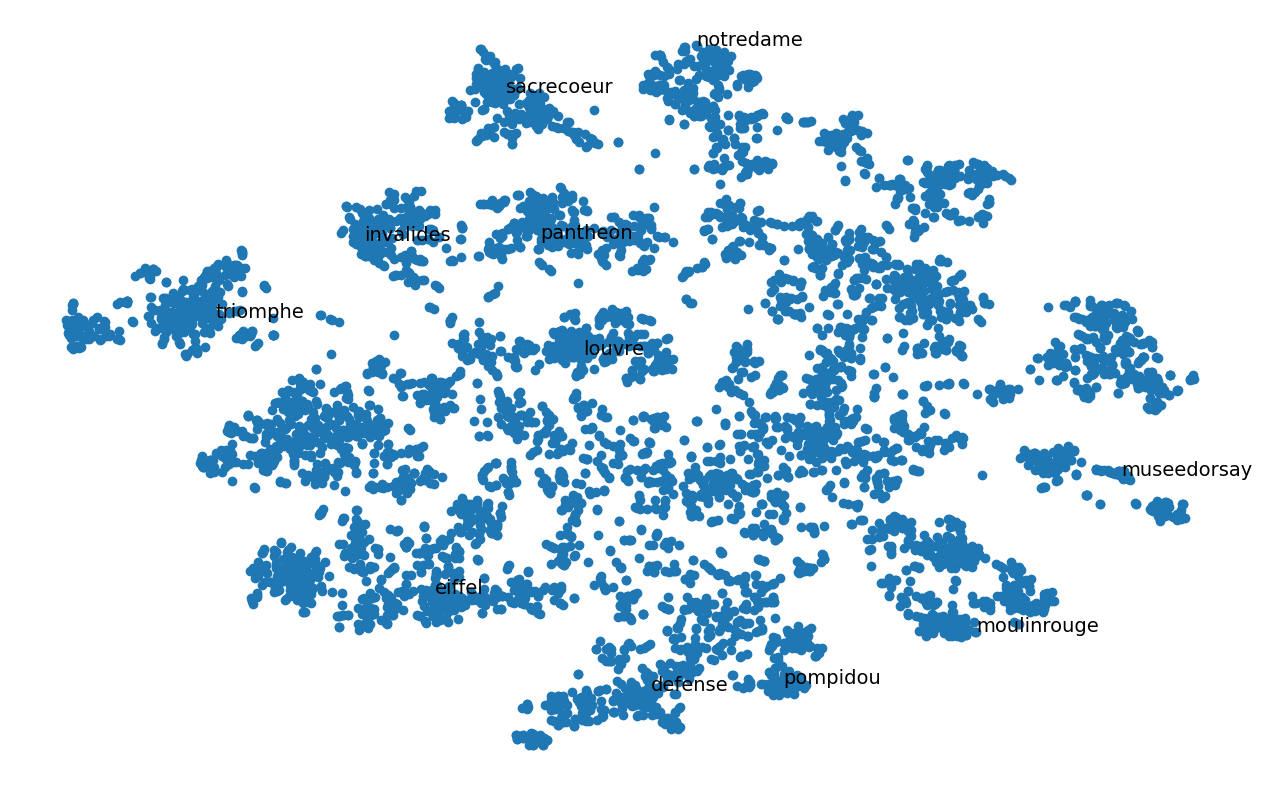

In [8]:
# Plot t-SNE
plt.figure(figsize=(16,10))
plt.scatter(tsne_result[:,0], tsne_result[:,1])
plt.axis('off')
for i, label in enumerate(labels):
    plt.annotate(label, (tsne_result[i,0], tsne_result[i,1]), fontsize=14)
plt.show()


/Users/morrisflorek/miniconda3/envs/env_pocIR/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


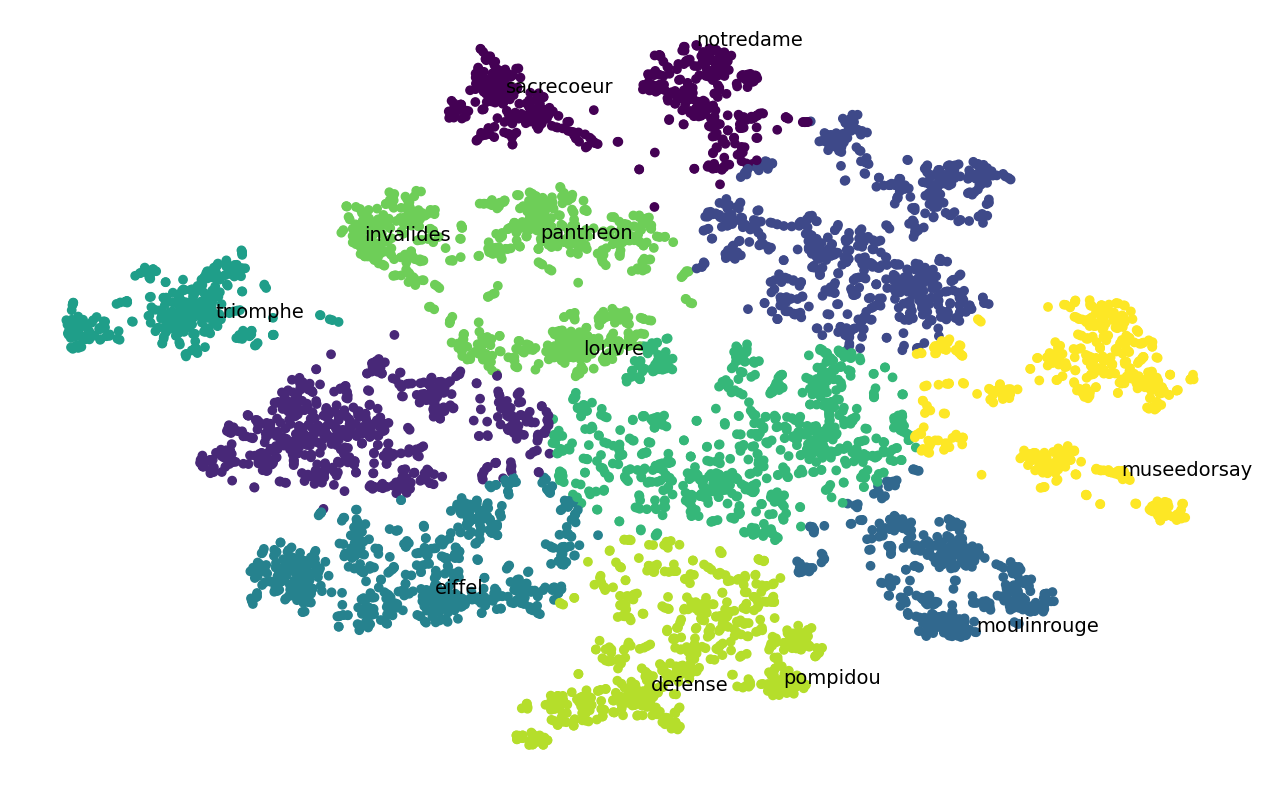

In [9]:
# K-Mean clustering
kmean = KMeans(n_clusters=10)
kmean.fit(tsne_result)

# Plot t-SNE with K-Mean clustering
plt.figure(figsize=(16,10))
plt.scatter(tsne_result[:,0], tsne_result[:,1], c=kmean.labels_)
plt.axis('off')
for i, label in enumerate(labels):
    plt.annotate(label, (tsne_result[i,0], tsne_result[i,1]), fontsize=14)
plt.show()